In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# Задача 2: Исследование оттока клиентов фитнес-центра

# Задания:

# Проверить данные на пропуски

# Посчитать общий процент оттока

# Построить столбчатую диаграмму оттока по полу

# Построить boxplot для возраста ушедших/оставшихся

# Рассчитать корреляцию между тренировками и оттоком

In [30]:
np.random.seed(42)

n_clients = 1000

data = {
    'client_id': range(1, n_clients + 1),
    'gender': np.random.choice(['М', 'Ж'], n_clients, p=[0.55, 0.45]),
    'age': np.random.normal(35, 10, n_clients).round(0).astype(int),
    'months_as_client': np.random.exponential(12, n_clients).round(0).astype(int),
    'workout_per_week': np.random.normal(2.5, 1.2, n_clients)
}

clients = pd.DataFrame(data)

clients['age'] = clients['age'].clip(18, 65)
clients['months_as_client'] = clients['months_as_client'].clip(1, 60)
clients['workout_per_week'] = clients['workout_per_week'].clip(0, 7).round(1)

def generate_churn(row):
    base_prob = 0.2
    if row['months_as_client'] < 3:
        base_prob += 0.15
    elif row['months_as_client'] > 24:
        base_prob -= 0.1
        
    if row['workout_per_week'] < 1:
        base_prob += 0.25
    elif row['workout_per_week'] > 4:
        base_prob -= 0.15
        
    if row['age'] < 25:
        base_prob += 0.1
        
    base_prob += np.random.uniform(-0.05, 0.05)
    
    return 1 if np.random.random() < base_prob else 0

clients['churned'] = clients.apply(generate_churn, axis=1)


In [31]:
clients.isnull().sum()

client_id           0
gender              0
age                 0
months_as_client    0
workout_per_week    0
churned             0
dtype: int64

In [32]:
clients.head()

,client_id,gender,age,months_as_client,workout_per_week,churned
0,1,М,37,43,4.0,0
1,2,Ж,22,5,2.0,0
2,3,Ж,39,8,2.4,1
3,4,Ж,41,3,2.6,0
4,5,М,41,11,3.5,0


In [33]:
clients.tail()

,client_id,gender,age,months_as_client,workout_per_week,churned
995,996,М,22,2,0.9,0
996,997,Ж,29,23,1.7,0
997,998,М,35,26,1.4,0
998,999,Ж,31,8,4.0,0
999,1000,М,28,1,2.0,1


In [34]:
clients.describe()

,client_id,age,months_as_client,workout_per_week,churned
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,36.133000,11.65500,2.511500,0.244000
std,288.819436,9.547065,11.20462,1.208486,0.429708
min,1.000000,18.000000,1.00000,0.000000,0.000000
25%,250.750000,29.000000,4.00000,1.675000,0.000000
50%,500.500000,36.000000,8.00000,2.500000,0.000000
75%,750.250000,42.000000,16.00000,3.300000,0.000000
max,1000.000000,65.000000,60.00000,7.000000,1.000000


In [35]:

f'Процент оттока клиентов: {((clients['churned'].sum()/clients['churned'].count())*100).round()}%'


'Процент оттока клиентов: 24.0%'

In [36]:
clients[clients['age'] == 65]['client_id']

835    836
Name: client_id, dtype: int64

In [37]:
clients[clients['client_id'] == 836]

,client_id,gender,age,months_as_client,workout_per_week,churned
835,836,М,65,3,3.8,0


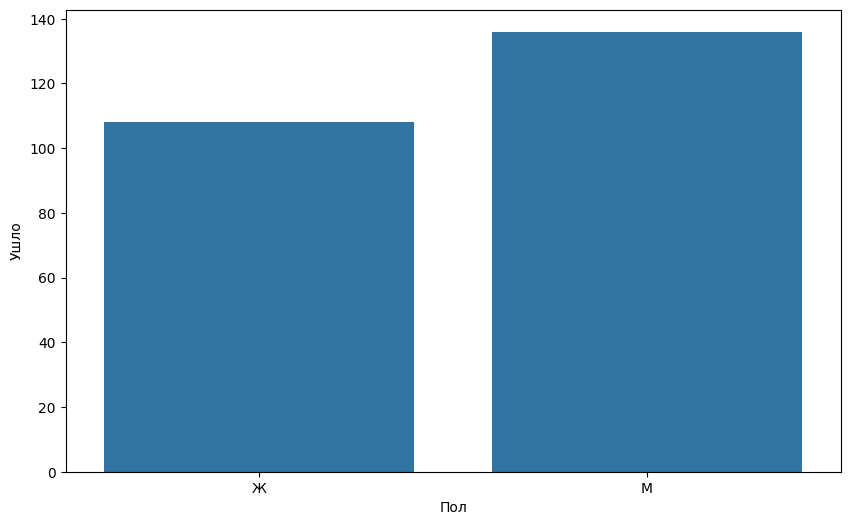

In [38]:
churned = clients.groupby('gender')['churned'].sum()
churned
plt.figure(figsize=(10,6))
plt.xlabel('Пол')
plt.ylabel('Ушло')
sns.barplot(churned);

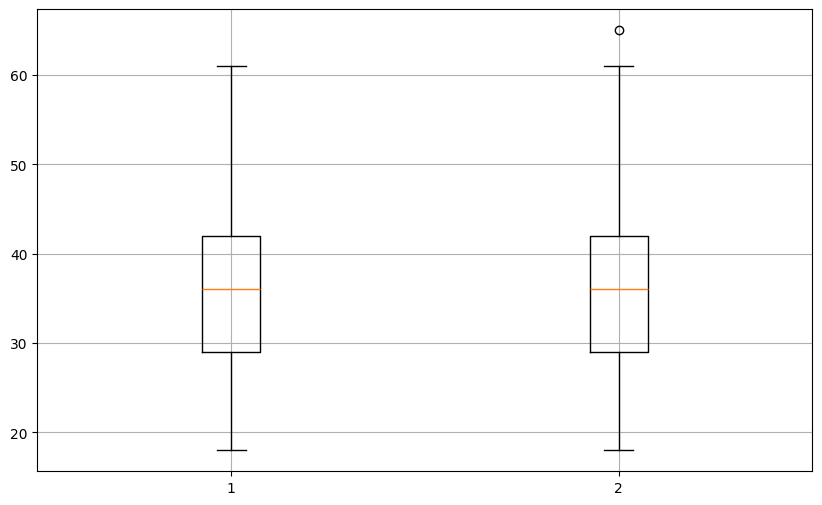

In [39]:
ages_churned = clients[clients['churned'] == 1]['age']
ages_active = clients[clients['churned'] == 0]['age']
plt.figure(figsize=(10,6))
plt.grid()
plt.boxplot([ages_churned,ages_active]);

In [40]:
#Далее будет создана сводная таблица, к которой будет применен метод линейной регрессии. В этой таблице будет опущен столбец с id клиента,
#также столбец 'gender' будет заменен на 'is_male', применим метод one-hot encoding для того, чтобы избавиться от категорийной переменной для
#правильного обучения модели.

In [41]:
df_for_reg = clients.copy()
df_for_reg['is_male'] = (clients['gender'] == 'М').astype(int)
feature = df_for_reg[['age','is_male', 'months_as_client', 'workout_per_week',]]
target = df_for_reg['churned']
model = LinearRegression()
model.fit(feature, target)
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_:.4f}")

Coefficients: [ 0.00034032 -0.00151664 -0.00579103 -0.06306727]
Intercept: 0.4584


In [42]:
#Из полученных коэффициентов видно, что наибольшее влияние на уход человека из клуба влияет регулярность тренировок и срок нахождения в клубе.
#Пол  и возраст имеют наименьшую ценность.

In [49]:
pearson_corr = df_for_reg['workout_per_week'].corr(df_for_reg['churned'])
corr = pearson_corr.round(4)
print(f"Pearson correlation: {corr}")
print(f"R^2 = {(corr**2).round(4)}")

Pearson correlation: -0.1764
R^2 = 0.0311


In [ ]:
#Наблюдаем слабую отрицательную корреляцию. 